In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, color, exposure

In [2]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19, decode_predictions
from tensorflow.keras.applications import EfficientNetB7

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Function to load and operate on the content and style images
def get_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
path = "/content/gdrive/MyDrive/MSiA432/DL Project/02. Modeling/"

## Starry Nights + 000001.jpg

In [7]:
content_image = load_img(path + '/Content/000001.jpg')
style_image = load_img(path + '/Style/The-Starry-Night-Van Gogh.jpeg')

Text(0.5, 1.0, 'Style Image')

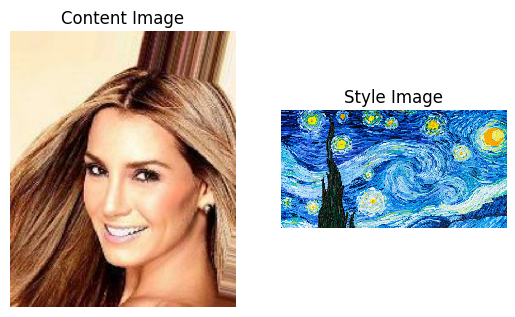

In [8]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(content_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Content Image')


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [9]:
eff_net = EfficientNetB7(include_top=False, weights='imagenet')

for layer in eff_net.layers:
  print(layer.name)

258076736/258076736 [==============================] - 1s 0us/step
input_1
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block1c_dwconv
block1c_bn
block1c_activation
block1c_se_squeeze
block1c_se_reshape
block1c_se_reduce
block1c_se_expand
block1c_se_excite
block1c_project_conv
block1c_project_bn
block1c_drop
block1c_add
block1d_dwconv
block1d_bn
block1d_activation
block1d_se_squeeze
block1d_se_reshape
block1d_se_reduce
block1d_se_expand
block1d_se_excite
block1d_project_conv
block1d_project_bn
block1d_drop
block1d_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activ

In [10]:
content_layers = ['block7b_project_conv'] 

# layer_name = ['1a','1b','1c','1d','2a','2b','2c','2d','2e','2f','2g','3a','3b',
#               '3c','3d','3e','3f','3g','4a','4b','4c','4d','4e','4f','4g','4h',
#               '4i','4j','5a','5b','5c','5d','5e','5f','5g','5h','5i','5j',
#               '6a','6b','6c','6d','6e','6f','6g','6h','6i','6j','6k','6l','6m',
#               '7a','7b','7c']

layer_name = ['1a','2a','3a','4a','5a','6a','7a']
style_layers = []

for each_layer in layer_name:
  #style_layers.append('block' + each_layer + '_dwconv')
  style_layers.append('block' + each_layer + '_project_conv')
print(style_layers)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

['block1a_project_conv', 'block2a_project_conv', 'block3a_project_conv', 'block4a_project_conv', 'block5a_project_conv', 'block6a_project_conv', 'block7a_project_conv']


In [11]:
def effnet_layers(layer_names):
  """ Creates a efficient nate model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  eff_net = EfficientNetB7(include_top=False, weights='imagenet')
  eff_net.trainable = False

  outputs = [eff_net.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([eff_net.input], outputs)
  return model

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.effnet = effnet_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.effnet.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    #preprocessed_input = preprocess_input(inputs)
    outputs = self.effnet(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [14]:
## Getting the targets
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
## Generated image
image = tf.Variable(content_image)

In [16]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1 #1e-2
content_weight=1e-4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [20]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


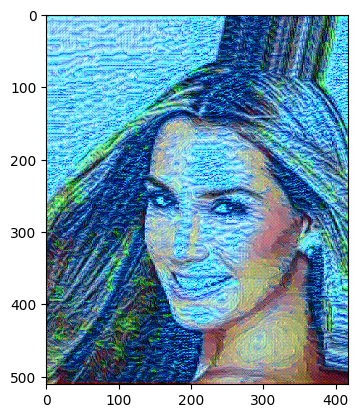

In [21]:
## VGG with tensor load
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Starry Nights + 000013.jpg

In [22]:
content_image = load_img(path + '/Content/000013.jpg')
style_image = load_img(path + '/Style/The-Starry-Night-Van Gogh.jpeg')

Text(0.5, 1.0, 'Style Image')

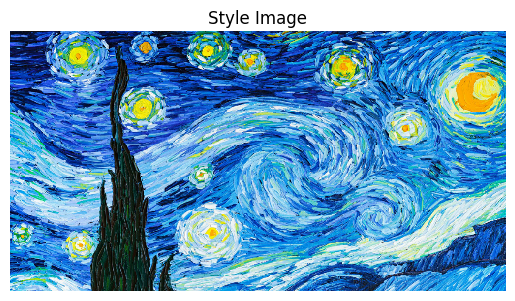

In [23]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [24]:
## Getting the targets
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [25]:
## Generated image
image = tf.Variable(content_image)

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [27]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [28]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [29]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


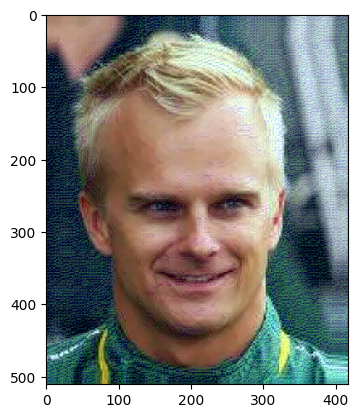

In [30]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## The Scream + 000001.jpg

In [31]:
content_image = load_img(path + '/Content/000001.jpg')
style_image = load_img(path + '/Style/the_scream.png')

Text(0.5, 1.0, 'Style Image')

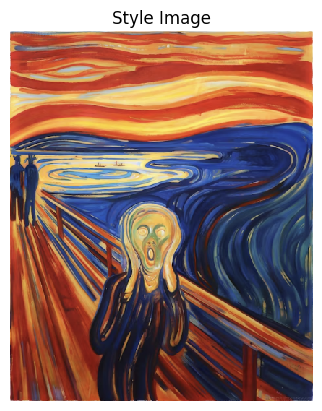

In [32]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [33]:
## Getting the targets
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [34]:
## Generated image
image = tf.Variable(content_image)

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [37]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [38]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


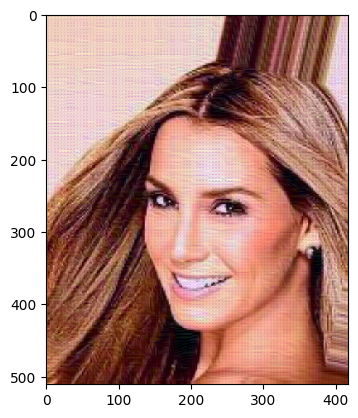

In [39]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## The Scream + 000013.jpg

In [40]:
content_image = load_img(path + '/Content/000013.jpg')
style_image = load_img(path + '/Style/the_scream.png')

Text(0.5, 1.0, 'Style Image')

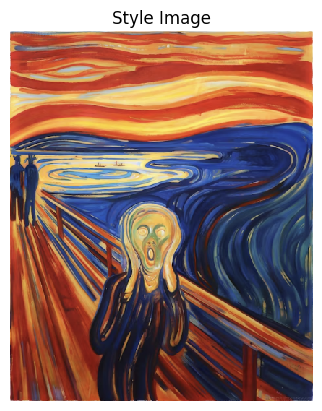

In [41]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [42]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [43]:
## Generated image
image = tf.Variable(content_image)

In [44]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [45]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [46]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [47]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


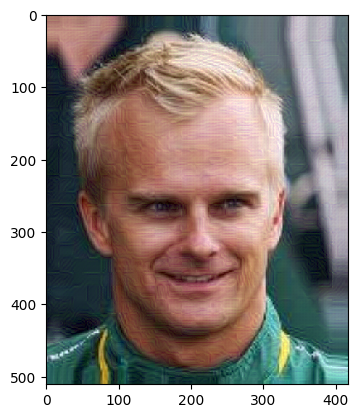

In [48]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')